<a href="https://colab.research.google.com/github/MUbarak123-56/cnn-vs-vit/blob/master/ResNet_food.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 5.3 MB/s 
     |████████████████████████████████| 212 kB 43.5 MB/s 
     |████████████████████████████████| 115 kB 47.0 MB/s 
     |████████████████████████████████| 163 kB 21.2 MB/s 
     |████████████████████████████████| 127 kB 51.1 MB/s 
     |████████████████████████████████| 115 kB 50.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 5.0 MB/s 
     |████████████████████████████████| 7.6 MB 43.8 MB/s 


In [2]:
from datasets import load_dataset

In [3]:
food = load_dataset("food101", split="train[:5000]")

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/.cache/huggingface/datasets/food101/default/0.0.0/7cebe41a80fb2da3f08fcbef769c8874073a86346f7fb96dc0847d4dfc318295. Subsequent calls will reuse this data.


In [4]:
food = food.train_test_split(test_size=0.2)
food_use = food.copy()
food["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7FEDE9278550>,
 'label': 81}

In [5]:
food

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})

In [6]:
labels = food["train"].features["label"].names

In [7]:
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [8]:
id2label[str(79)]

'prime_rib'

**Visualizing data**

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

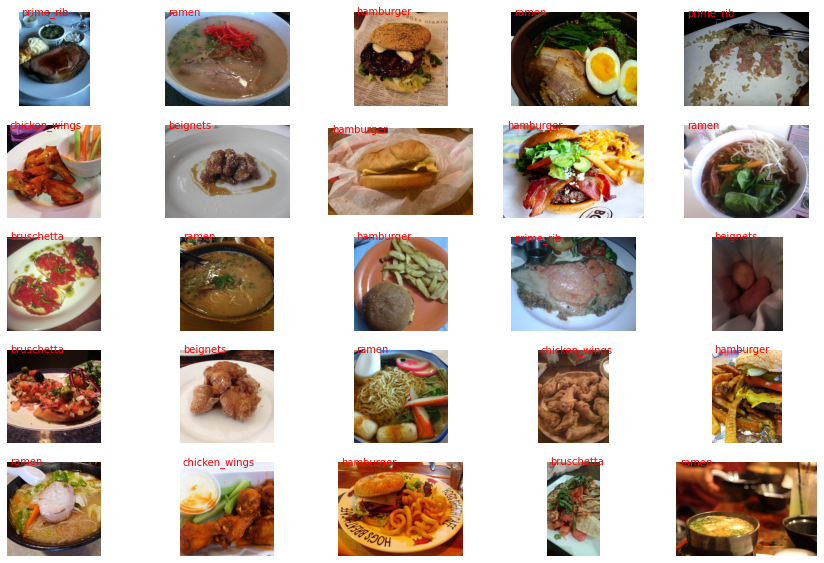

In [10]:
fig, axArr = plt.subplots(5,5,figsize=(15,10));
# loop through all rows
for currRow in range(5):
 # loop through all columns
 for currCol in range(5):
 # select the random digi
  n = np.random.randint(0,len(food["train"]))
  randomDigitImage = food["train"][n]["image"]
  randomDigitLabel = id2label[str(food["train"][n]["label"])]
 
 # plot it
  currentAxis = axArr[currRow,currCol];
  currentAxis.axis('off');
 
  currentAxis.imshow(randomDigitImage);
  currentAxis.text(13,15,str(randomDigitLabel),color='red',fontsize=10);


## **Model Training**

In [11]:
from transformers import AutoFeatureExtractor
#ResNetForImageClassification

In [12]:
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-50")


Downloading:   0%|          | 0.00/266 [00:00<?, ?B/s]

In [13]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_transforms = Compose([RandomResizedCrop(feature_extractor.size), ToTensor(), normalize])

In [14]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [15]:
food = food.with_transform(transforms)

In [16]:
from transformers import DefaultDataCollator
data_collator = DefaultDataCollator()

In [18]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
model = AutoModelForImageClassification.from_pretrained(
    "microsoft/resnet-50",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([101, 2048]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    evaluation_strategy="steps",
    num_train_epochs=4,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=food["train"],
    eval_dataset=food["test"],
    tokenizer=feature_extractor,
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4000
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1000


Step,Training Loss,Validation Loss
100,1.874300,1.868036
200,1.197300,1.089395
300,0.780300,0.830278
400,0.711900,0.695662
500,0.670800,0.663084
600,0.660800,0.563256
700,0.649100,0.573900
800,0.634100,0.546289
900,0.586000,0.552083
1000,0.656500,0.542973


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-100
Configuration saved in ./results/checkpoint-100/config.json
Model weights saved in ./results/checkpoint-100/pytorch_model.bin
Feature extractor saved in ./results/checkpoint-100/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-200
Configuration saved in ./results/checkpoint-200/config.json
Model weights saved in ./results/checkpoint-200/pytorch_model.bin
Feature extractor saved in ./results/checkpoint-200/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to ./results/checkpoint-300
Configuration saved in ./results/checkpoint-300/config.json
Model weights saved in ./results/checkpoint-300/pytorch_model.bin
Feature extractor saved in ./results/checkpoint-300/preprocessor_config.json
Deleting older checkpoint

TrainOutput(global_step=1000, training_loss=0.9925568399429321, metrics={'train_runtime': 375.6508, 'train_samples_per_second': 42.593, 'train_steps_per_second': 2.662, 'total_flos': 3.42697791356928e+17, 'train_loss': 0.9925568399429321, 'epoch': 4.0})

## **Test set Evaluation**

chicken_wings


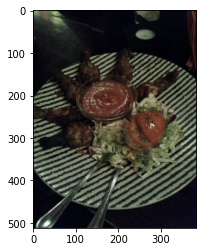

In [20]:
plt.imshow(food_use["test"][0]["image"])
print(id2label[str(food["test"][0]["label"])])

In [21]:
preds_output = trainer.predict(food["test"])

***** Running Prediction *****
  Num examples = 1000
  Batch size = 8


In [22]:
preds_output.metrics

{'test_loss': 0.5161209106445312,
 'test_runtime': 10.2166,
 'test_samples_per_second': 97.88,
 'test_steps_per_second': 12.235}

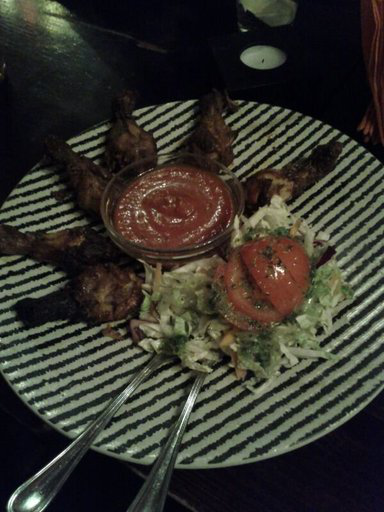

In [23]:
food_use["test"][0]["image"]

In [24]:
actual = food_use["test"][0]["label"]
predictions = preds_output.label_ids

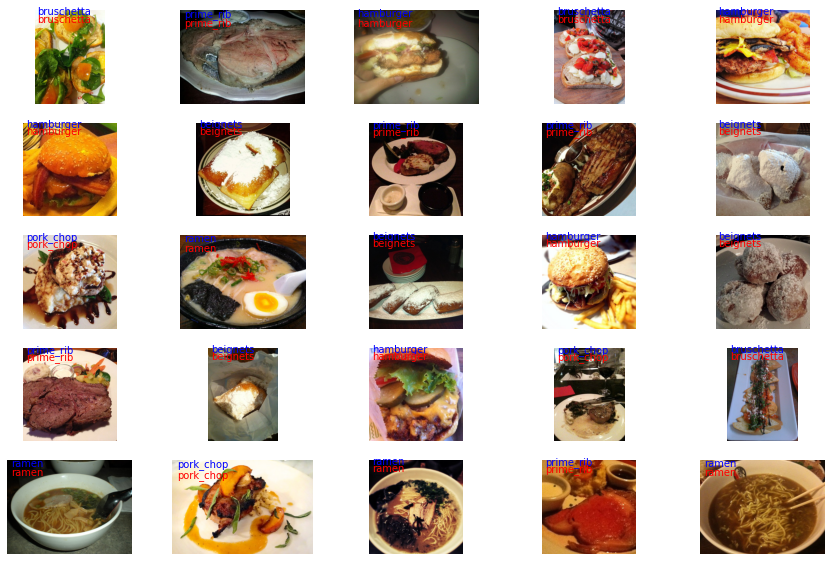

In [25]:
fig, axArr = plt.subplots(5,5,figsize=(15,10));
# loop through all rows
for currRow in range(5):
 # loop through all columns
 for currCol in range(5):
 # select the random digi
  n = np.random.randint(0,len(food_use["test"]))
  randomDigitImage = food_use["test"][n]["image"]
  randomDigitLabel = id2label[str(food_use["test"][n]["label"])]
  prediction = id2label[str(preds_output.label_ids[n])]
 
 # plot it
  currentAxis = axArr[currRow,currCol];
  currentAxis.axis('off');
 
  currentAxis.imshow(randomDigitImage);
  currentAxis.text(15,25,str(randomDigitLabel),color='blue',fontsize=10);
  currentAxis.text(15,65,str(prediction),color='red',fontsize=10);

In [26]:
import pandas as pd

In [27]:
actual = food_use["test"][:]["label"]
predictions = preds_output.label_ids
df_result = pd.DataFrame({"actual":actual,"predicted":predictions})
df_result

,actual,predicted
0,20,20
1,10,10
2,53,53
3,6,6
4,77,77
...,...,...
995,20,20
996,81,81
997,53,53
998,79,79


In [28]:
correct = len(df_result[df_result["actual"] == df_result["predicted"]])
incorrect = len(df_result[df_result["actual"] != df_result["predicted"]])

print("Proportion of Correct Predictions:%.2f"%((correct)/(correct+incorrect)))
print("Proportion of Inorrect Predictions:%.2f"%((incorrect)/(correct+incorrect)))

Proportion of Correct Predictions:1.00
Proportion of Inorrect Predictions:0.00
